In [4]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import (
    RandomWalkMobilityModel,
    MandateMobilityModel
)
import epimodel.viz.mandate_wearing as mw

from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.prior_posterior as pp

import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
import json

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set_style("white")


import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw

In [13]:
# argparser = argparse.ArgumentParser()
# argparser.add_argument('--model', dest='model', type=str, help='Model type')
# argparser.add_argument('--filter', dest='filtered', type=str, help='How to remove regions')
# argparser.add_argument('--masks', dest='masks', type=str, help='Which mask feature')
# argparser.add_argument('--w_par', dest='w_par', type=str, help='Which wearing parameterisation')
# argparser.add_argument('--mob', dest='mob', type=str, help='Which wearing parameterisation')
# args, _ = argparser.parse_known_args()

MODEL = "cases" #args.model
FILTERED = "nofilter" #args.filtered
MASKS = "mandate" #args.masks
W_PAR = "exp" # None

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

TUNING = 750 #1000
DRAWS = 500
CHAINS = 4

if MASKS == "mandate":
    n_mandates = 2
    
GRADUAL = True

# Gradual mandate run

In [146]:
path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
df = pd.read_csv(path)
df = df.set_index(["country", "date"]) 
col = "H6_Facial Coverings"


def set_gradual_mandate(cdf, mandate, days=7):
    cdf.loc[mandate, "H6_Facial Coverings"] = 0
    increment = 1 / days
    for i in range(1, days+1):
        d = mandate + timedelta(days = i)
        if d <= pd.to_datetime("2020-09-21") and d >= pd.to_datetime("2020-05-01"):
            cdf.loc[d, "H6_Facial Coverings"] = i * increment
    print(cdf)
    return cdf
        

def set_gradual_announced_mandate(cdf, mandate, days=7):
    cdf.loc[mandate, "H6_Facial Coverings"] = 0
    increment = 1 / (days*2)
    announce = mandate - timedelta(days = days)
    
    for i in range(days*2 +1):
        d = announce + timedelta(days = i)
        if d <= pd.to_datetime("2020-09-21") and d >= pd.to_datetime("2020-05-01"):
            cdf.loc[d, "H6_Facial Coverings"] = i * increment
    
    return cdf

def make_gradual_dataset(Rs, df, days=7, announce=False):
    mandate_rs_by_date = mw.get_mandates_by_date(Rs, df)

    df2 = pd.DataFrame()
    for c in data.Rs:
        cdf = df.loc[c]
        cdf["country"] = c
        cdf.index = pd.to_datetime(cdf.index)

        if c in mandate_rs_by_date:
            switches_on = mw.get_mandate_switches(cdf, col)
            mandate = switches_on.index[0]
            if announce:
                cdf = set_gradual_announced_mandate(cdf, mandate, days=days)
            else:
                cdf = set_gradual_mandate(cdf, mandate, days=days)
        
        df2 = pd.concat([df2, cdf])
    
    return df2

DAYS = 7
df2 = make_gradual_dataset(data.Rs, df, days = DAYS, announce=True)
df2.to_csv(f"../data/modelling_set/master_data_gradual_announced{DAYS}.csv")

<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["country"] = c
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["country"] = c
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["country"] = c
/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-146-5355a5fc3fd4>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [163]:
# prep data object

if GRADUAL:
    path = f"../data/modelling_set/master_data_gradual_mandates{DAYS}.csv"
else:
    path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

if MASKS == "mandate":
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True, n_mandates=n_mandates)
if MASKS == "wearing":
    print(MASKS)
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True)

masks_object.make_preprocessed_object()
data = masks_object.data



../data/modelling_set/master_data_gradual_mandates7.csv
['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'H6_Facial Coverings', 'H6_Facial Coverings_3plus', 'avg_mobility_no_parks_no_residential']
Masking May cases in US states
centering NPIs


In [164]:
print("How many regions?:", len(data.Rs))
print("How many NPIs?:", len(data.CMs))
print("How many days?:", len(data.Ds))

#len(data.Rs)* (len(data.Ds) - 30)
data.CMs

How many regions?: 92
How many NPIs?: 12
How many days?: 144


['C1_School closing',
 'C1_School closing_full',
 'C2_Workplace closing',
 'C2_Workplace closing_full',
 'C4_Restrictions on gatherings_3plus',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C4_Restrictions on gatherings_2plus',
 'C4_Restrictions on gatherings_full',
 'H6_Facial Coverings',
 'avg_mobility_no_parks_no_residential',
 'H6_Facial Coverings_3plus']

In [165]:
# model specification
ep = EpidemiologicalParameters()
bd = ep.get_model_build_dict()


def set_init_infections(data, d):
    n_masked_days = 10
    first_day_new = data.NewCases[:, n_masked_days]
    first_day_new = first_day_new[first_day_new.mask == False]
    median_init_size = np.median(first_day_new)

    if median_init_size == 0:
        median_init_size = 50

    d["log_init_mean"] = np.log(median_init_size)
    d["log_init_sd"] = np.log(median_init_size)  # TODO: wide


set_init_infections(data, bd)

bd['wearing_parameterisation'] = W_PAR


if MODEL == "cases":
    del bd["deaths_delay_mean_mean"]
    del bd["deaths_delay_mean_sd"]
    del bd["deaths_delay_disp_mean"]
    del bd["deaths_delay_disp_sd"]

    
if MASKS == "mandate":
    bd['n_mandates'] = 1
    #bd['mask_mean'] = 0.2 / bd['n_mandates']
    bd['mask_sigma'] = 0.2
    
print(bd)
print(W_PAR)

{'gi_mean_mean': 5.06, 'gi_mean_sd': 0.3265, 'gi_sd_mean': 2.11, 'gi_sd_sd': 0.5, 'cases_delay_mean_mean': 10.92830227448381, 'cases_delay_mean_sd': 0.9387435298564465, 'cases_delay_disp_mean': 5.406593726647138, 'cases_delay_disp_sd': 0.2689502951493133, 'log_init_mean': 5.457455587886334, 'log_init_sd': 5.457455587886334, 'wearing_parameterisation': 'exp', 'n_mandates': 1, 'mask_sigma': 0.2}
exp


/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [166]:
if MASKS == "wearing":
    with RandomWalkMobilityModel(data) as model:
        model.build_model(**bd)
        
elif MASKS == "mandate":
    with MandateMobilityModel(data) as model:
        model.build_model(**bd)
    

MASS = 'adapt_diag' 

with model:
    model.trace = pm.sample(
        DRAWS,
        tune=TUNING,
        cores=CHAINS,
        chains=CHAINS,
        max_treedepth=12,
        target_accept=0.9,
        init=MASS,
    )

10429
Argument: wearing_parameterisation not being used


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Psi, InitialSize_log, GI_sd, GI_mean, r_walk_noise, r_walk_noise_scale, RegionR_noise, HyperRVar, HyperRMean, Mobility_Alpha, Mandate_Alpha_2, Mandate_Alpha_1, CM_Alpha]


Sampling 4 chains for 750 tune and 500 draw iterations (3_000 + 2_000 draws total) took 10000 seconds.


In [167]:
trace = model.trace

In [8]:
dt = datetime.datetime.now().strftime("%m-%d-%H:%M")
Rs = data.Rs

if MASKS == 'wearing':
    idstr = f"pickles/{MASKS}_{W_PAR}_{MODEL}_countries_{len(Rs)}_{dt}"
else:
    idstr = f"pickles/{MASKS}_2and3_{MODEL}_countries_{len(Rs)}_{dt}"

pickle.dump(model.trace, open(idstr + ".pkl", 'wb'))

with open(idstr + "_cols", "w") as f:
    f.write( ", ".join(data.CMs) )

In [155]:
var = ["CMReduction"]
if MASKS == "wearing" :
    var += ["WearingReduction"]
else :
    var += ["MandateReduction"]
var += ["MobilityReduction"]

#var += ["HyperRVar", "HyperRMean"]

s = pm.summary(model.trace, var_names=var, hdi_prob=0.95)
#npi_cols = data.CMs[:-2] + [data.CMs[-1]] + [data.CMs[-2]]
#s.index = npi_cols
s

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
CMReduction[0],0.987,0.045,0.892,1.071,0.001,0.001,2283.0,2265.0,2333.0,1294.0,1.0
CMReduction[1],0.965,0.045,0.874,1.049,0.001,0.001,1901.0,1901.0,1970.0,1080.0,1.0
CMReduction[2],0.976,0.033,0.910,1.039,0.001,0.000,2569.0,2569.0,2599.0,1663.0,1.0
CMReduction[3],0.938,0.048,0.841,1.028,0.001,0.001,1536.0,1536.0,1565.0,1592.0,1.0
CMReduction[4],0.972,0.049,0.875,1.068,0.001,0.001,2796.0,2796.0,2849.0,1316.0,1.0
CMReduction[5],0.996,0.037,0.922,1.065,0.001,0.001,2170.0,2169.0,2156.0,1531.0,1.0
CMReduction[6],0.996,0.041,0.912,1.076,0.001,0.001,2417.0,2411.0,2486.0,1562.0,1.0
CMReduction[7],1.057,0.059,0.961,1.187,0.001,0.001,2286.0,2206.0,2576.0,1437.0,1.0
CMReduction[8],0.982,0.040,0.903,1.059,0.001,0.001,2095.0,2095.0,2215.0,1541.0,1.0
MandateReduction[0],0.995,0.042,0.911,1.074,0.001,0.001,1365.0,1359.0,1375.0,1404.0,1.0


In [160]:
np.median(model.trace.MandateReduction)

0.9942738398243297

In [10]:
s = pm.summary(model.trace, var_names=["HyperRVar", "HyperRMean", "r_walk_noise_scale"], hdi_prob=0.95)
#s = pm.summary(model.trace, var_names=["Wearing_HyperV"], hdi_prob=0.95)

s

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
HyperRVar,0.233,0.024,0.186,0.278,0.001,0.001,578.0,569.0,585.0,657.0,1.0
HyperRMean,0.831,0.030,0.774,0.889,0.002,0.001,348.0,346.0,349.0,597.0,1.0
r_walk_noise_scale,0.192,0.015,0.160,0.219,0.001,0.000,791.0,791.0,793.0,747.0,1.0


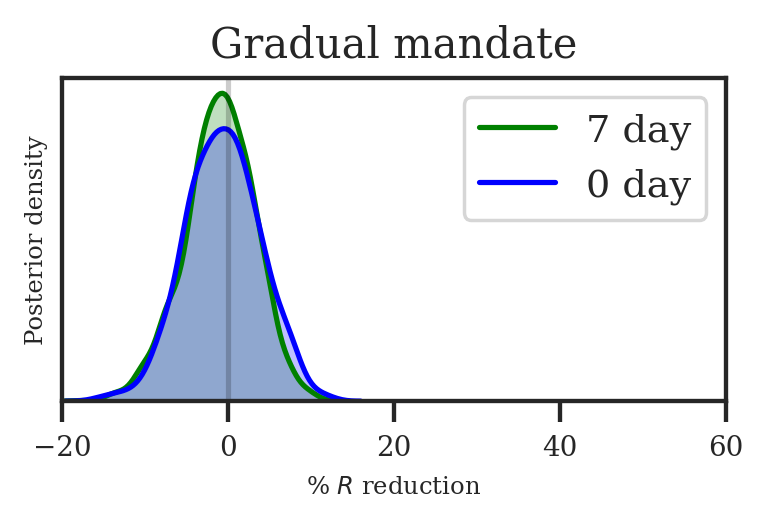

In [169]:
def main_result_posteriors(grad, old, ax, both_runs=False):
    sns.kdeplot(grad, label="7 day", color="green", shade=True, ax=ax)
    sns.kdeplot(old, label="0 day", color="blue", shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction", fontsize=7)
    ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    if both_runs:
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, fontsize=7, frameon=False)
    
    ax.set_ylabel("Posterior density", fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=8)
    plt.title("Gradual mandate")

    
with open("../outputs/mandate_reduction_samples.txt", "r") as f :
    mred = f.read()
    mred = np.array(mred.split("\n")[:-1]).astype(np.float64)
    
PNAS_WIDTH_INCHES = 3.4252
fig = plt.figure(figsize=(PNAS_WIDTH_INCHES,PNAS_WIDTH_INCHES *0.5), dpi=250)
red = (1 - trace.MandateReduction.flatten()) * 100
ax = plt.gca()
main_result_posteriors(red, mred, ax)
plt.savefig(f"../outputs/gradual_posterior.pdf", bbox_inches="tight")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HyperRVar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8798474394019418, but should be close to 0.8. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


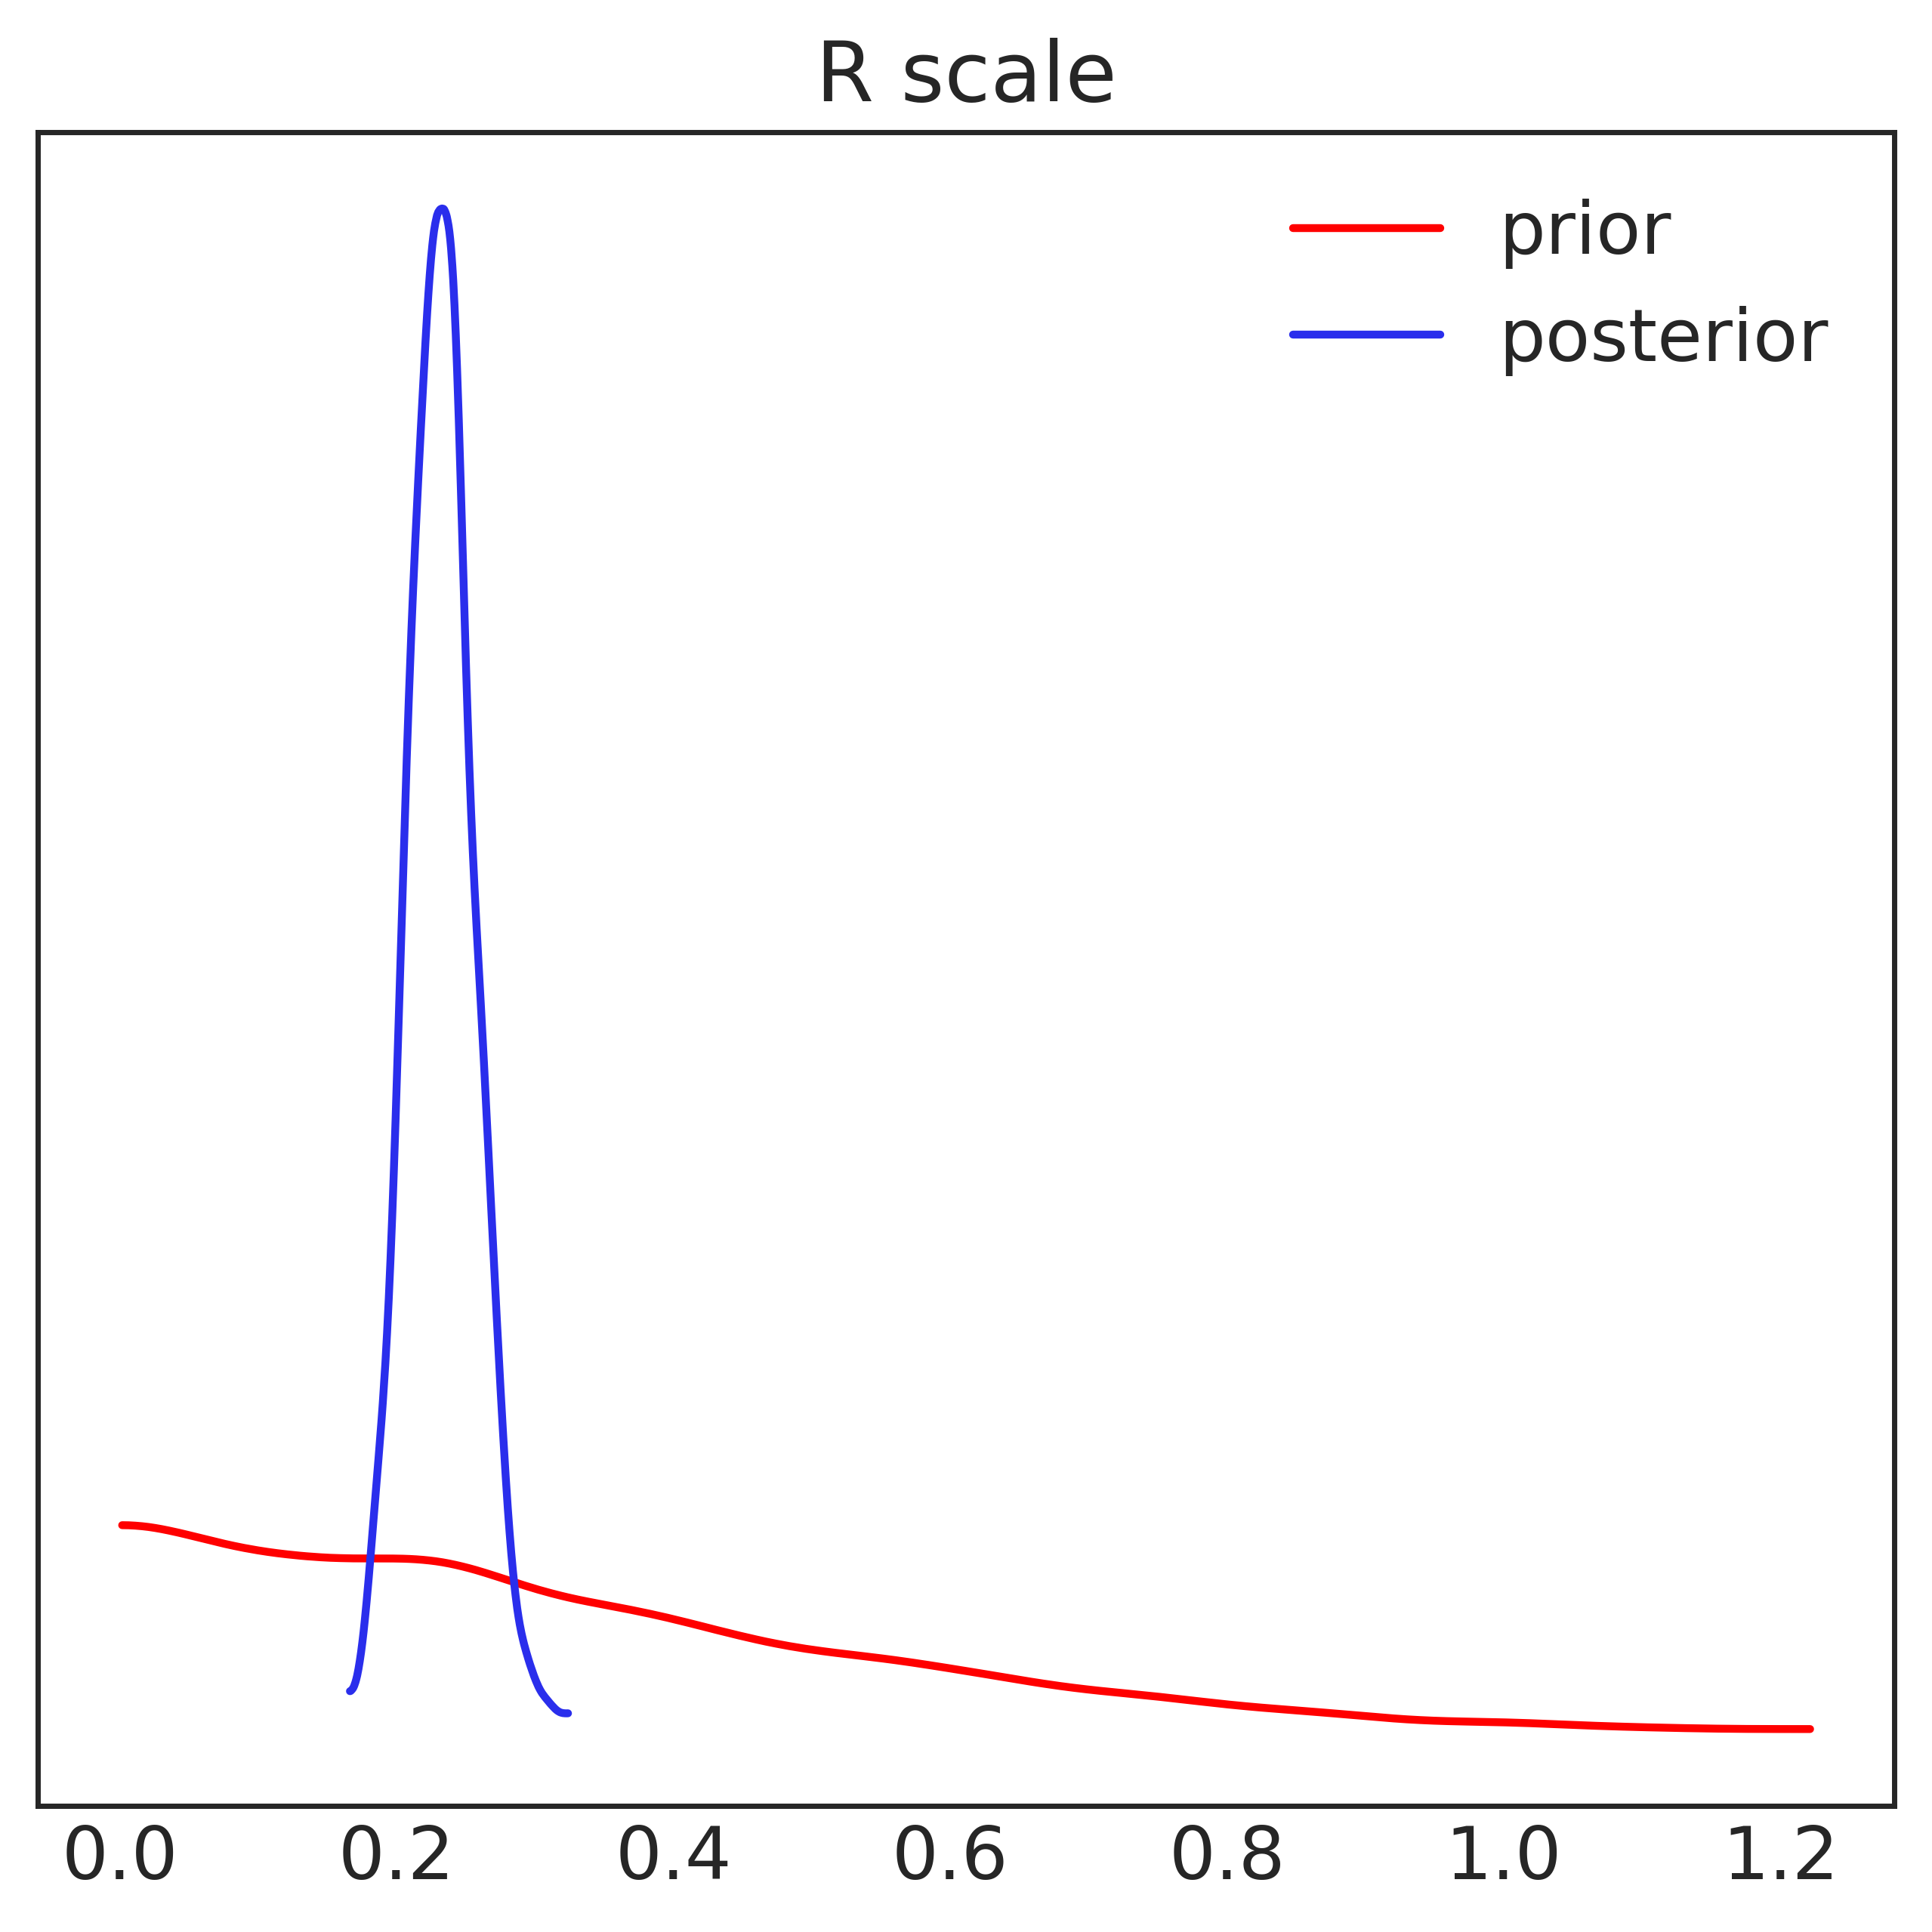

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [HyperRMean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


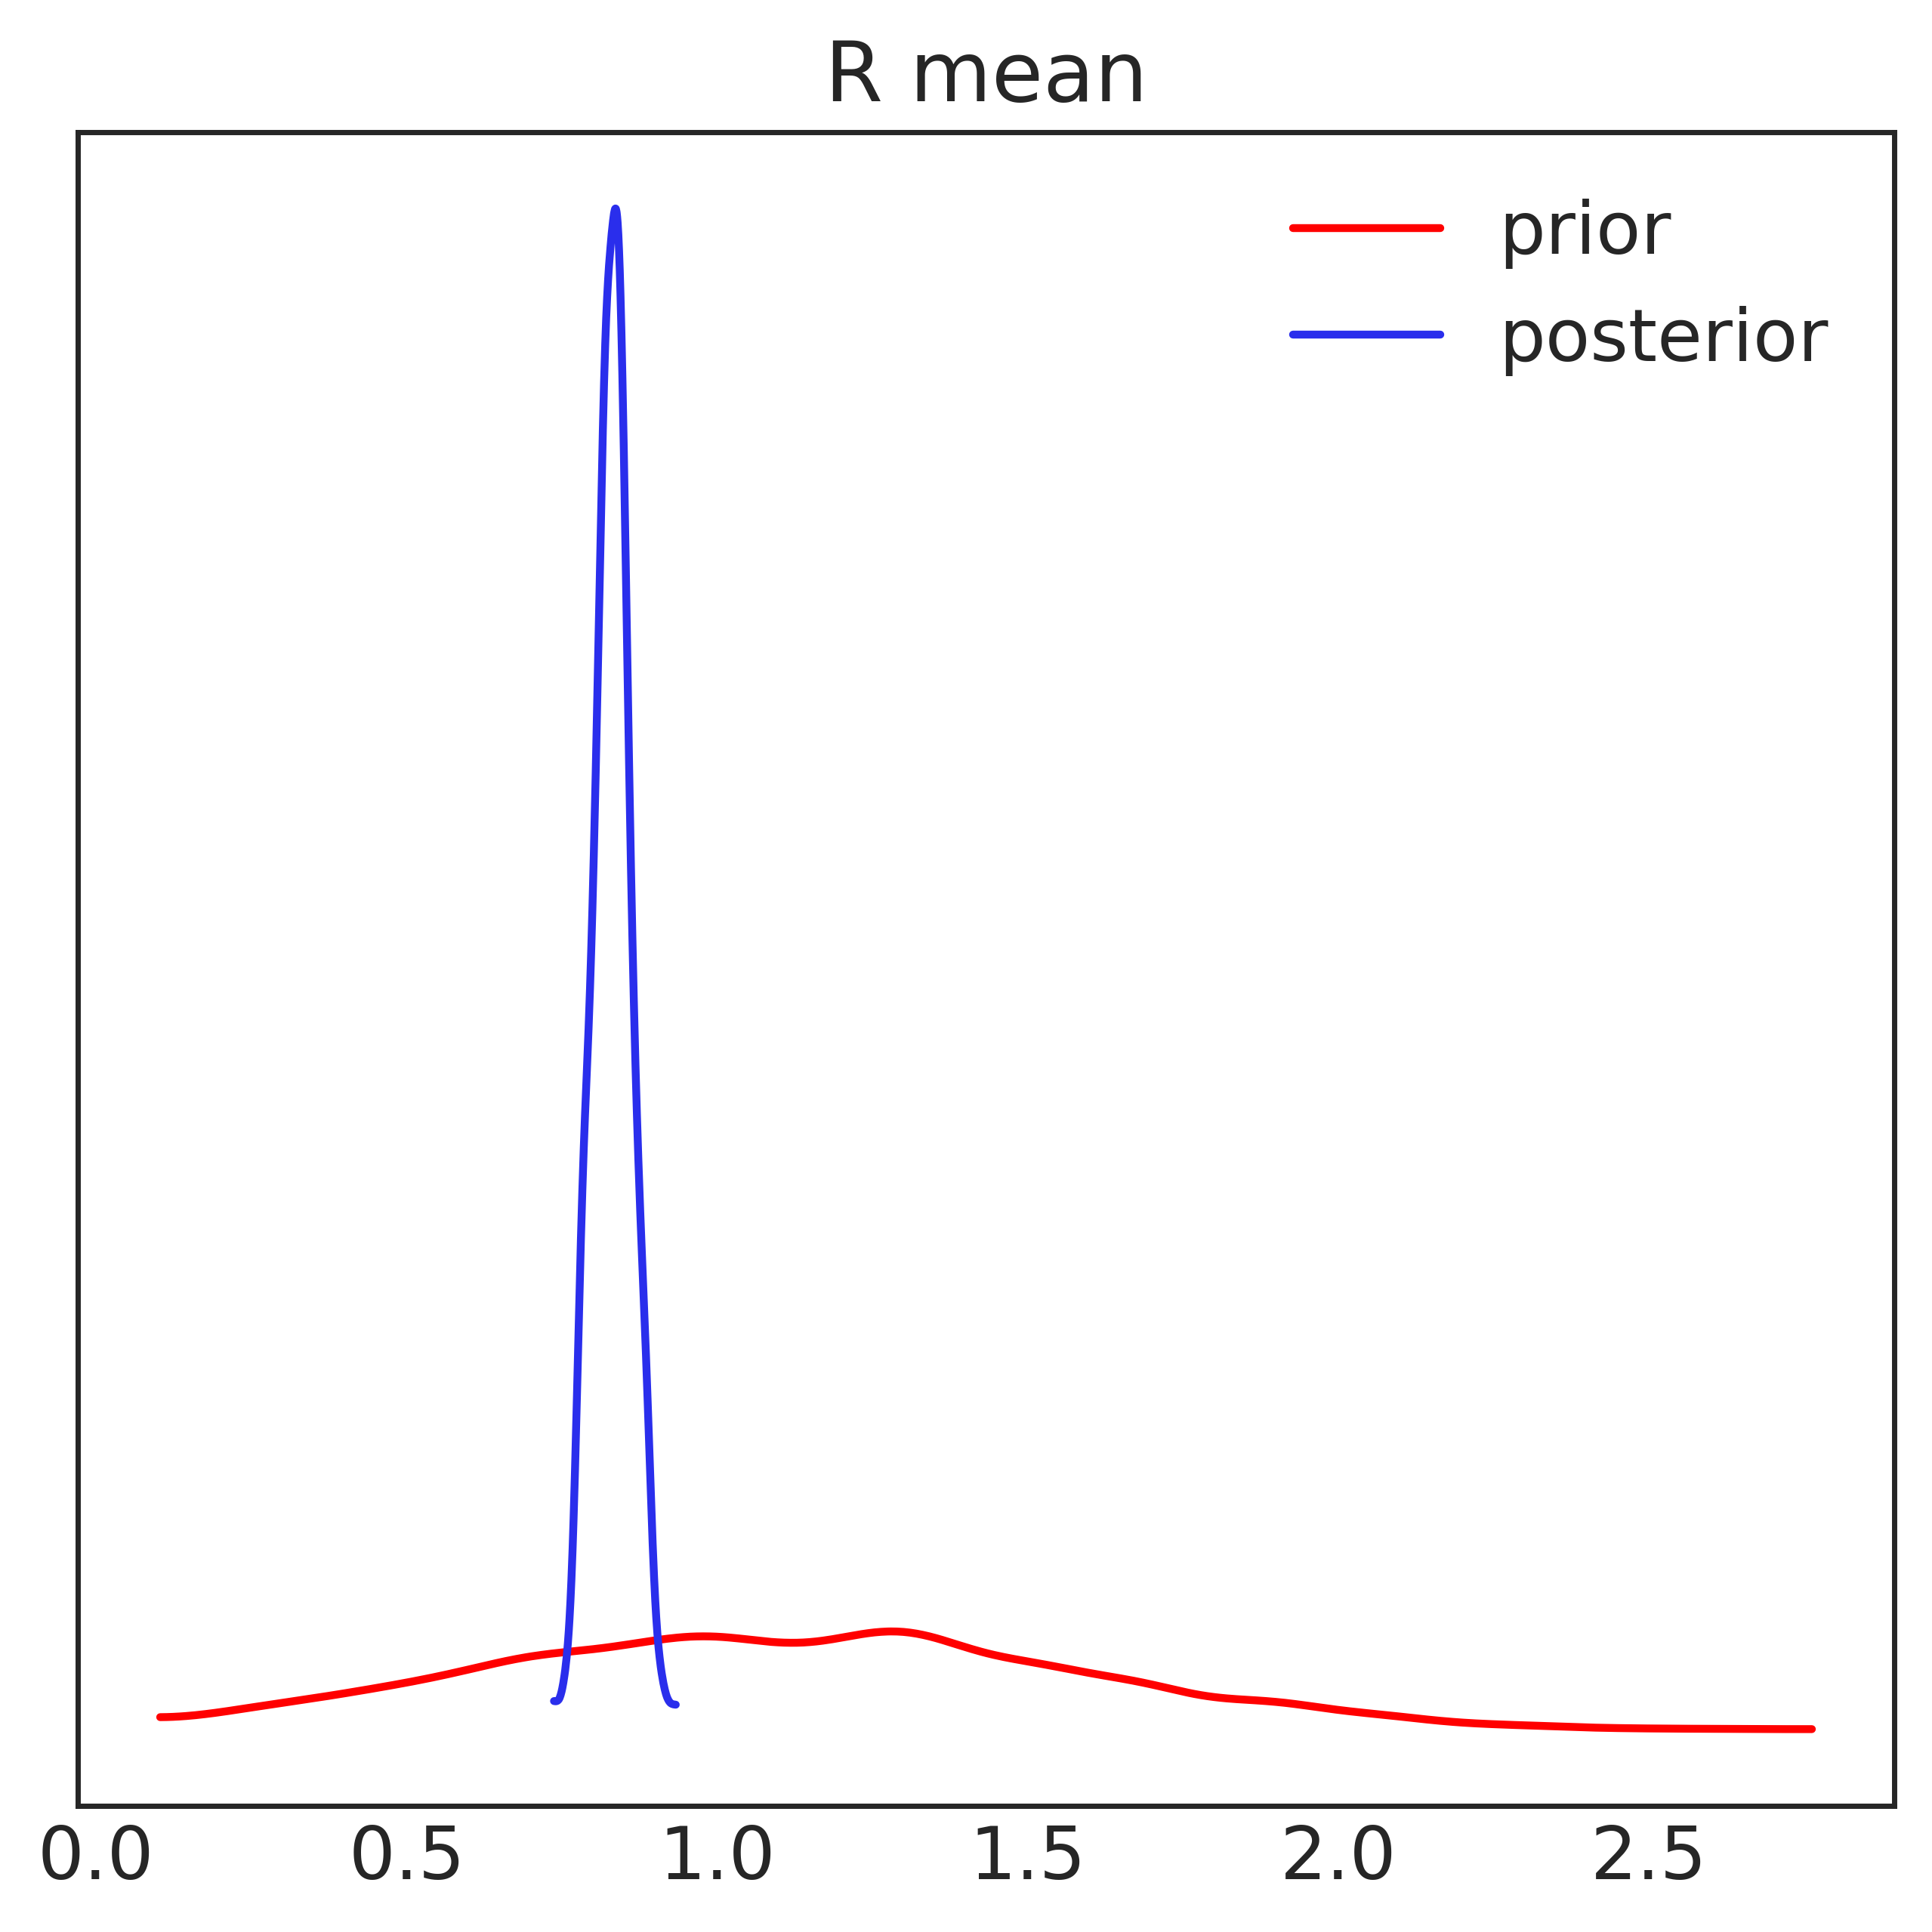

In [12]:
if "HyperRVar" in trace.varnames:
    with pm.Model() as mr:
        pm.HalfNormal("HyperRVar", sigma=0.4)
        mr.trace = pm.sample(1000)

    pp.prior_posterior_plot(mr.trace.HyperRVar, trace.HyperRVar, t="R scale")
    
    
if "HyperRMean" in trace.varnames:
    with pm.Model() as mr:
        pm.TruncatedNormal("HyperRMean", mu=1.07, sigma=0.5, lower=0.1)
        mr.trace = pm.sample(1000)

    pp.prior_posterior_plot(mr.trace.HyperRMean, trace.HyperRMean, t="R mean")
    
if "Wearing_HyperV" in trace.varnames:
    with pm.Model() as w:
        pm.HalfNormal("Wearing_HyperV", sigma=0.07)
        w.trace = pm.sample(1000)

    pp.prior_posterior_plot(w.trace.Wearing_HyperV, trace.Wearing_HyperV, t="wearing scale")


/home/gleech/.cache/pypoetry/virtualenvs/epimodel-mWKUaee4-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


ValueError: 'percent_mc' is not in list

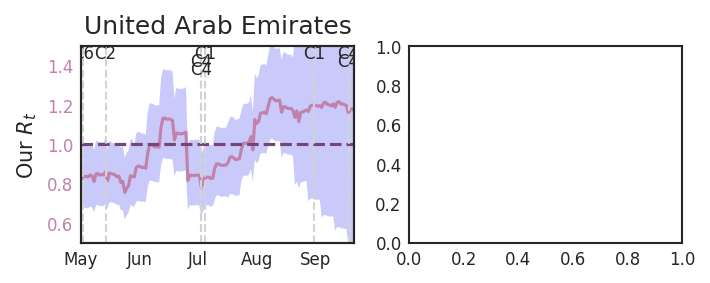

In [13]:
Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")

def load_oxcgrt(use_us=True):
    OXCGRT_PATH = "../data/raw/OxCGRT_latest.csv"
    oxcgrt = pd.read_csv(OXCGRT_PATH, parse_dates=["Date"], low_memory=False)
    # Drop regional data
    nat = oxcgrt[oxcgrt.Jurisdiction == "NAT_TOTAL"]

    # Add US states
    if use_us:
        states = oxcgrt[
            (oxcgrt.CountryName == "United States")
            & (oxcgrt.Jurisdiction == "STATE_TOTAL")
        ]
        # Drop GEO to prevent name collision
        nat = nat[nat.CountryName != "Georgia"]
        states.CountryName = states.RegionName
        states = states.replace("Georgia", "Georgia-US")
        nat = pd.concat([nat, states])

    i = list(nat.columns).index("Date")
    nat.columns = list(nat.columns[:i]) + ["date"] + list(nat.columns[i + 1 :])

    return nat[nat.date.isin(Ds)]


maxes = {
    "C1": 3, 
    "C2": 3, 
    "C3": 2, 
    "C4": 4, 
    "C5": 2, 
    "C6": 3, 
    "C7": 2, 
    "C8": 4, 
    "H1": 2
}

def subindex(df, c) :
    x = df[c] - 0.5 * (1 - df[c[:2] + "_Flag"] )
    return (x / maxes[c[:2]]) * 100


# now with no weight on regional
def nat_subindex(df, c) :
    x = df[c] * df[c[:2] + "_Flag"] 
    return (x / maxes[c[:2]]) * 100

# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md
def stringency(data, national=True):
    if national: 
        sub = nat_subindex
    else :
        sub = subindex
    
    df = data.copy()
    new_stringency_codes = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "H1"]
    nonflags = [c for c in data.columns if "Flag" not in c]
    new_stringency_cols = [c for c in nonflags if c[:2] in new_stringency_codes]
    
    for c in new_stringency_cols:
        if c[:2] != "C8":
            df[c] = sub(df, c)
        else :
            df[c] = df[c] / maxes[c[:2]] * 100
    
    return df[new_stringency_cols].mean(axis=1).round(2)


oxcgrt = load_oxcgrt()
oxcgrt = oxcgrt[oxcgrt.date.isin(Ds)]
oxcgrt["StringencyIndexNational"] = stringency(oxcgrt)

def load_rts() :
    third_party_rts_us = pd.read_csv("../data/raw/us_rt_live.csv", parse_dates=["date"])
    third_party_rts_us
    us_state_abbrev = {    'Alabama': 'AL',    'Alaska': 'AK',    'American Samoa': 'AS',    'Arizona': 'AZ',    'Arkansas': 'AR',    'California': 'CA',    'Colorado': 'CO',    'Connecticut': 'CT',    'Delaware': 'DE',    'District of Columbia': 'DC',    'Florida': 'FL',    'Georgia': 'GA',    'Guam': 'GU',    'Hawaii': 'HI',    'Idaho': 'ID',    'Illinois': 'IL',    'Indiana': 'IN',    'Iowa': 'IA',    'Kansas': 'KS',    'Kentucky': 'KY',    'Louisiana': 'LA',    'Maine': 'ME',    'Maryland': 'MD',    'Massachusetts': 'MA',    'Michigan': 'MI',    'Minnesota': 'MN',    'Mississippi': 'MS',    'Missouri': 'MO',    'Montana': 'MT',    'Nebraska': 'NE',    'Nevada': 'NV',    'New Hampshire': 'NH',    'New Jersey': 'NJ',    'New Mexico': 'NM',    'New York': 'NY',    'North Carolina': 'NC',    'North Dakota': 'ND',    'Northern Mariana Islands':'MP',    'Ohio': 'OH',    'Oklahoma': 'OK',    'Oregon': 'OR',    'Pennsylvania': 'PA',    'Puerto Rico': 'PR',    'Rhode Island': 'RI',    'South Carolina': 'SC',    'South Dakota': 'SD',    'Tennessee': 'TN',    'Texas': 'TX',    'Utah': 'UT',    'Vermont': 'VT',    'Virgin Islands': 'VI',    'Virginia': 'VA',    'Washington': 'WA',    'West Virginia': 'WV',    'Wisconsin': 'WI',    'Wyoming': 'WY'}
    us_state_abbrev = {value:key for key, value in us_state_abbrev.items()}
    third_party_rts_us.region = third_party_rts_us.region.replace(us_state_abbrev)
    third_party_rts_us.region = third_party_rts_us.region.replace({"Georgia": "Georgia-US"})
    cols = ['date', 'region', 'mean', 'lower_80', 'upper_80']
    third_party_rts_us = third_party_rts_us[cols]

    # http://epidemicforecasting.org/country-rt-estimates
    epifor_rts = pd.read_csv("../data/raw/r_estimates_epifor.csv", parse_dates=["Date"])
    epifor_rts = epifor_rts[epifor_rts.EnoughData == 1]
    epifor_rts = epifor_rts[epifor_rts.Date.isin(Ds)]
    epifor_rts.Date = epifor_rts.Date.dt.date #pd.to_datetime(epifor_rts.Date, utc=True)

    def recode(epifor_rts) :
        with open("../data/raw/3166.json") as f:
            codes = json.load(f)
            codes = codes['3166-1']

        a2 = [c.get("alpha_2") for c in codes]
        names = [c.get("name") for c in codes]
        map_ = {c: n for c, n in zip(a2, names)}
        epifor_rts["region"] = epifor_rts.Code
        epifor_rts.region = epifor_rts.Code.replace(map_)
        epifor_rts.region = epifor_rts.region.replace({"Tanzania, United Republic of": "Tanzania"})
        epifor_rts.region = epifor_rts.region.replace({"Viet Nam": "Vietnam"})
        epifor_rts.region = epifor_rts.region.replace({"Korea, Republic of": "South Korea"})

        return epifor_rts

    epifor_rts = recode(epifor_rts)
    epifor_rts.columns = ["code", "date", "mean", "std", "enough", "region"]

    z80 = 0.842
    epifor_rts["lower_80"] = epifor_rts["mean"] - z80 * epifor_rts["std"]
    epifor_rts["upper_80"] = epifor_rts["mean"] + z80 * epifor_rts["std"]
    #epifor_rts = epifor_rts[cols]
    third_party_rts = pd.concat([epifor_rts, third_party_rts_us])
    third_party_rts.date = pd.to_datetime(third_party_rts.date)
    
    # Correct for absence of case delay in Epifor
    third_party_rts["mean_minus10"] = third_party_rts["mean"].shift(-10)
    return third_party_rts

third_party_rts = load_rts()


for r in data.Rs :
    rp.reprod_plot(trace, data, masks_object.df, oxcgrt, third_party_rts, r, start_d_i=0) 
    plt.show()

In [ ]:
for region in data.Rs :
    pc.epicurve_plot(data, oxcgrt, trace, region)



In [ ]:
pp.plot_all_pps(trace)